In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf

%matplotlib inline
pd.options.display.float_format = '{:,.5f}'.format

In [215]:
SDG_zscore = pd.read_csv("whole_data_price.csv")
US_stock = pd.read_csv('UScompanies.csv')

US_stocks = list(US_stock.Ticker_new.unique())
SDG_zscore_US = SDG_zscore[SDG_zscore['Ticker'].isin(US_stocks)]
SDG_zscore_US.head()

C:\Program1\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (109,110) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,COMPANY,DATE,SDG_1,z_score_1,COUNT_1,MA_1,MA2_1,SDG_MOM_1,SDG_2,...,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
0,0,ABBOTT LABORATORIES,2015-02-19,-0.89552,-0.44185,1.00000,nan,nan,nan,-0.89552,...,46.08500,46.61000,"6,590,305.00000",0.00000,1.00000,42.35952,42.64277,42.10825,42.58795,"6,590,305.00000"
1,1,ABBOTT LABORATORIES,2015-02-20,nan,nan,nan,nan,nan,nan,nan,...,46.40000,47.48000,"6,512,461.00000",0.00000,1.00000,42.51485,43.46511,42.39607,43.38287,"6,512,461.00000"
2,2,ABBOTT LABORATORIES,2015-02-21,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,3,ABBOTT LABORATORIES,2015-02-22,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,4,ABBOTT LABORATORIES,2015-02-23,-3.04569,-1.50274,1.00000,nan,nan,nan,nan,...,47.02350,47.32000,"5,608,147.00000",0.00000,1.00000,43.24582,43.40115,42.96577,43.23668,"5,608,147.00000"


In [216]:
# we average all 17 sdg z-scores to get z_score_agg

SDG_zscore_US.drop(SDG_zscore_US[['Unnamed: 0', 'ISSUERID', 'ISSUER_CUSIP', 'ISSUER_SEDOL', 'ISSUER_ISIN', 
                                  'ISSUER_CNTRY_DOMICILE', 'IVA_PREVIOUS_RATING', 'IVA_RATING_TREND'
                                 , 'SDG_average', 'zscore_average', 'MA_average']], axis=1, inplace=True)

SDG_zscore_US = SDG_zscore_US.fillna(0)
Names=['z_score_'+str(i+1) for i in range(17)]
SDG_zscore_US["z_score_agg"] = SDG_zscore_US[Names].apply('mean',axis=1)
SDG_stm_US = SDG_zscore_US[['COMPANY', 'DATE', 'Ticker', 'z_score_agg', 'Sector', 'yr_n']]
grouped = SDG_stm_US.groupby(['Ticker', 'DATE', 'Sector'])['z_score_agg'].mean().reset_index()
grouped.rename(columns = {'z_score_agg': 'SDG z-score'}, inplace = True)
grouped.head()

C:\Program1\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Ticker,DATE,Sector,SDG z-score
0,A,2015-02-19,Health Care,0.03777
1,A,2015-02-20,Health Care,0.00000
2,A,2015-02-21,Health Care,0.00000
3,A,2015-02-22,Health Care,0.00000
4,A,2015-02-23,Health Care,0.26516


In [6]:
grouped['DATE'] = pd.to_datetime(grouped['DATE'])
grouped.index = grouped['DATE']
#grouped.resample('W-Mon').agg({'SDG z-score': 'mean'})


In [7]:
weekly_grouped=grouped.groupby(['Ticker','Sector']).resample('W-Mon').agg({'SDG z-score': 'mean'}).reset_index()

In [8]:
weekly_grouped.head()

,Ticker,Sector,DATE,SDG z-score
0,A,Health Care,2015-02-23,0.06059
1,A,Health Care,2015-03-02,0.05734
2,A,Health Care,2015-03-09,0.07348
3,A,Health Care,2015-03-16,-0.06836
4,A,Health Care,2015-03-23,0.28315


### Read Financial Data

In [13]:
# Calculate Log Return for those companies in a weekly basis
stock2015 = pd.read_csv("stock_price_year_2015.csv")
stock2016 = pd.read_csv("stock_price_year_2016.csv")
stock2017 = pd.read_csv("stock_price_year_2017.csv")
stock2018 = pd.read_csv("stock_price_year_2018.csv")
prices = pd.concat([stock2015, stock2016, stock2017, stock2018])
prices = prices[prices['Ticker'].isin(grouped['Ticker'])]
prices['Log_price'] = np.log(prices.Adj_Close)

prices['Log_ret'] = prices.groupby('Ticker')['Log_price'].transform(pd.Series.diff)
prices['Date'] = pd.to_datetime(prices['Date'])
prices=prices.dropna()
weekly_prices=prices.set_index('Date').groupby(['Ticker']).resample('W-Mon').agg({'Log_ret': 'sum'})
weekly_prices.head()

Log_ret
Ticker Date               
A      2015-01-05 -0.01892
       2015-01-12  0.00776
       2015-01-19 -0.04748
       2015-01-26  0.02326
       2015-02-02 -0.01182

In [14]:
# Downloaded sp500 data in the past few years and merge this table with log return of companies.
import pandas_datareader as pdr
sp_data=pdr.get_data_yahoo('^GSPC','2015-01-01','2018-12-31')

sp_data['Log_ret_sp']=np.log(sp_data['Adj Close']/sp_data['Adj Close'].shift(1))
weekly_sp_data=sp_data.resample('W-Mon').agg({'Log_ret_sp': 'sum'})
weekly_sp_data=weekly_sp_data.reset_index().dropna()
weekly_sp_data['Date']=pd.to_datetime(weekly_sp_data['Date'])

weekly_prices=weekly_prices.reset_index().dropna()
weekly_sp_data=weekly_sp_data.reset_index().dropna()
merged=weekly_prices.merge(weekly_sp_data[['Date','Log_ret_sp']],on='Date',how='inner').dropna()
merged['excess_return']=merged['Log_ret']-merged['Log_ret_sp']
merged=merged.sort_values(['Ticker','Date'])
merged.head()

,Ticker,Date,Log_ret,Log_ret_sp,excess_return
0,A,2015-01-05,-0.01892,-0.01845,-0.00047
377,A,2015-01-12,0.00776,0.00379,0.00397
754,A,2015-01-19,-0.04748,-0.00437,-0.04311
1131,A,2015-01-26,0.02326,0.01848,0.00477
1508,A,2015-02-02,-0.01182,-0.01777,0.00595


In [9]:
#merged=merged.to_csv('excess_return.csv')
#merged=pd.read_csv('excess_return.csv')

In [20]:
# computed sdg zscore change, z_score standard deviation as well as absolute value of zscore change
# created a dummy variable 
# groupby dataframe in a weekly basis for merging with log return("merged" dataframe) in the future
SDG_stm_US['z_score_change']=SDG_stm_US.groupby('Ticker')['z_score_agg'].transform(pd.Series.diff)
SDG_stm_US=SDG_stm_US.rename(columns={'TICKER':'Ticker','DATE':'Date','SECTOR':'Sector'}).dropna()
SDG_stm_US['Date']=pd.to_datetime(SDG_stm_US['Date'])
weekly_sdg=SDG_stm_US.set_index('Date').groupby(['Ticker','Sector']).resample('W-Mon').agg({'z_score_change': 'sum'}).reset_index()
weekly_sdg['z_score_change_sd']=weekly_sdg.groupby('Ticker')['z_score_change'].rolling(20).std().reset_index()['z_score_change']
weekly_sdg=weekly_sdg.dropna()
weekly_sdg['z_score_change_abs']=np.abs(weekly_sdg['z_score_change'])
weekly_sdg['compare']=weekly_sdg.apply(lambda x: 0 if x.z_score_change_abs<=1.5*x.z_score_change_sd else 1,axis=1)
weekly_sdg.head(40)

C:\Program1\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Ticker,Sector,Date,z_score_change,z_score_change_sd,z_score_change_abs,compare
19,A,Health Care,2015-07-06,0.32084,0.46982,0.32084,0
20,A,Health Care,2015-07-13,-0.40876,0.47596,0.40876,0
21,A,Health Care,2015-07-20,0.13351,0.46623,0.13351,0
22,A,Health Care,2015-07-27,-0.21107,0.44834,0.21107,0
23,A,Health Care,2015-08-03,0.25544,0.45208,0.25544,0
24,A,Health Care,2015-08-10,0.10796,0.45269,0.10796,0
25,A,Health Care,2015-08-17,-0.27519,0.45708,0.27519,0
26,A,Health Care,2015-08-24,0.09956,0.45764,0.09956,0
27,A,Health Care,2015-08-31,-0.41491,0.46690,0.41491,0
28,A,Health Care,2015-09-07,0.46617,0.47474,0.46617,0


In [22]:
# merge two dataframe and create new columns: excess return lag 1 and mean_0_1
weekly_sdg['Date']=pd.to_datetime(weekly_sdg['Date'])
merged['Date']=pd.to_datetime(merged['Date'])
df=pd.merge(weekly_sdg,merged,on=['Ticker','Date'],how='inner')
#df.to_csv('D:/dataset/for_regression.csv')

df['excess_return_1']=df.groupby('Ticker')['excess_return'].shift(-1)
df['mean_0_1']=(df['excess_return']+df['excess_return_1'])/2
df2=df.dropna()
df2.head()

,Ticker,Sector,Date,z_score_change,z_score_change_sd,z_score_change_abs,compare,Log_ret,Log_ret_sp,excess_return,excess_return_1,mean_0_1
0,A,Health Care,2015-07-06,0.32084,0.46982,0.32084,0,0.01588,0.00539,0.01049,0.00033,0.00541
1,A,Health Care,2015-07-13,-0.40876,0.47596,0.40876,0,0.01513,0.01480,0.00033,-0.01107,-0.00537
2,A,Health Care,2015-07-20,0.13351,0.46623,0.13351,0,0.00250,0.01357,-0.01107,0.01761,0.00327
3,A,Health Care,2015-07-27,-0.21107,0.44834,0.21107,0,-0.01130,-0.02891,0.01761,0.01989,0.01875
4,A,Health Care,2015-08-03,0.25544,0.45208,0.25544,0,0.03449,0.01460,0.01989,-0.01593,0.00198


### Across all sectors, all SDGs

no_lag, regress excess_return on sdg_zscore_change

In [14]:
model = smf.ols(formula = "excess_return ~ z_score_change + compare", data = df2)
print ('all sectors')
fit = model.fit(cov_type = 'HAC', cov_kwds={'maxlags':2})
print (fit.summary())

all sectors
                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.237
Date:                Mon, 05 Aug 2019   Prob (F-statistic):             0.0145
Time:                        15:03:52   Log-Likelihood:             1.3429e+05
No. Observations:               70658   AIC:                        -2.686e+05
Df Residuals:                   70655   BIC:                        -2.685e+05
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0001      0

no_lag, regress excess_return on dummy*sdg_zscore_change and sdg_zscore_change

In [15]:
df2['compare_sdg_zscore_change'] = df2['compare']*df2['z_score_change']
model = smf.ols(formula = "excess_return ~ z_score_change + compare_sdg_zscore_change", data = df2)
print ('all sectors, no lags, dummy variable times sdg_zscore_change')
fit = model.fit(cov_type = 'HAC', cov_kwds={'maxlags':2})
print (fit.summary())


all sectors, no lags, dummy variable times sdg_zscore_change
                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.036
Date:                Mon, 05 Aug 2019   Prob (F-statistic):             0.0177
Time:                        15:03:53   Log-Likelihood:             1.3429e+05
No. Observations:               70658   AIC:                        -2.686e+05
Df Residuals:                   70655   BIC:                        -2.685e+05
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

C:\Program1\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


lag_1

In [16]:
model = smf.ols(formula = "excess_return_1 ~ z_score_change + compare", data = df2)
print ('all sectors')
fit = model.fit(cov_type = 'HAC', cov_kwds={'maxlags':2})
print (fit.summary())
print ('intercept is '+ str(fit.params[0]))
print ('coefficient of compare is '+ str(fit.params[2]))
print ('coefficient of z_score_change is '+ str(fit.params[1]))
print ('p_value of intercept is ' + str(fit.pvalues[0]))
print ('p_value of compare is ' + str(fit.pvalues[2]))
print ('p_value of z_score_change is ' + str(fit.pvalues[1]))

all sectors
                            OLS Regression Results                            
Dep. Variable:        excess_return_1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.520
Date:                Mon, 05 Aug 2019   Prob (F-statistic):            0.00401
Time:                        15:03:55   Log-Likelihood:             1.3418e+05
No. Observations:               70658   AIC:                        -2.684e+05
Df Residuals:                   70655   BIC:                        -2.683e+05
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0002      0

In [17]:
model = smf.ols(formula = "excess_return_1 ~  compare_sdg_zscore_change+z_score_change", data = df2)
print ('all sectors, lag_1, dummy variable times sdg_zscore_change')
fit = model.fit(cov_type = 'HAC', cov_kwds={'maxlags':2})
print (fit.summary())


all sectors, lag_1, dummy variable times sdg_zscore_change
                            OLS Regression Results                            
Dep. Variable:        excess_return_1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.544
Date:                Mon, 05 Aug 2019   Prob (F-statistic):             0.0786
Time:                        15:03:55   Log-Likelihood:             1.3418e+05
No. Observations:               70658   AIC:                        -2.683e+05
Df Residuals:                   70655   BIC:                        -2.683e+05
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

mean_0_1

In [18]:
model = smf.ols(formula = "mean_0_1 ~ z_score_change + compare", data = df2)
print ('all sectors')
fit = model.fit(cov_type = 'HAC', cov_kwds={'maxlags':2})
print (fit.summary())
print ('intercept is '+ str(fit.params[0]))
print ('coefficient of compare is '+ str(fit.params[2]))
print ('coefficient of z_score_change is '+ str(fit.params[1]))
print ('p_value of intercept is ' + str(fit.pvalues[0]))
print ('p_value of compare is ' + str(fit.pvalues[2]))
print ('p_value of z_score_change is ' + str(fit.pvalues[1]))

all sectors
                            OLS Regression Results                            
Dep. Variable:               mean_0_1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     10.84
Date:                Mon, 05 Aug 2019   Prob (F-statistic):           1.96e-05
Time:                        15:03:56   Log-Likelihood:             1.5965e+05
No. Observations:               70658   AIC:                        -3.193e+05
Df Residuals:                   70655   BIC:                        -3.193e+05
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0001      0

In [19]:
model = smf.ols(formula = "mean_0_1 ~ compare_sdg_zscore_change+z_score_change", data = df2)
print ('all sectors, mean_0_1, dummy variable times sdg_zscore_change')
fit = model.fit(cov_type = 'HAC', cov_kwds={'maxlags':2})
print (fit.summary())

all sectors, mean_0_1, dummy variable times sdg_zscore_change
                            OLS Regression Results                            
Dep. Variable:               mean_0_1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.394
Date:                Mon, 05 Aug 2019   Prob (F-statistic):           0.000615
Time:                        15:03:57   Log-Likelihood:             1.5965e+05
No. Observations:               70658   AIC:                        -3.193e+05
Df Residuals:                   70655   BIC:                        -3.193e+05
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

### All SDGs, by sector

no_lag

In [20]:
df2.groupby('Sector')['Ticker'].nunique()

Sector
Communication Services    19
Consumer Discretionary    47
Consumer Staples          28
Energy                    28
Financials                42
Health Care               47
Industrials               50
Information Technology    56
Materials                 19
Real Estate               27
Utilities                 27
Name: Ticker, dtype: int64

In [21]:
keys=list(df2['Sector'].unique())
values=list(np.arange(1,12))
reference=dict(zip(keys,values))
reference                   

{'Health Care': 1,
 'Consumer Discretionary': 2,
 'Information Technology': 3,
 'Consumer Staples': 4,
 'Utilities': 5,
 'Financials': 6,
 'Materials': 7,
 'Industrials': 8,
 'Real Estate': 9,
 'Energy': 10,
 'Communication Services': 11}

In [22]:
p_values_i=[]
p_values_dummy=[]
p_values_z=[]
coef_i=[]
coef_dummy=[]
coef_z=[]

In [23]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [24]:
for i in keys:
    df_sector=df2[df2['Sector']==i]
    model = smf.ols(formula = "excess_return ~ z_score_change + compare", data = df_sector)
    print (i)
    fit = model.fit(cov_type = 'HAC', cov_kwds={'maxlags':2})
    print (fit.summary())
    coef_i.append(fit.params[0])
    coef_dummy.append(fit.params[2])
    coef_z.append(fit.params[1])
    p_values_i.append(fit.pvalues[0])
    p_values_dummy.append(fit.pvalues[2])
    p_values_z.append(fit.pvalues[1])
    print('\n')

Health Care
                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.708
Date:                Mon, 05 Aug 2019   Prob (F-statistic):              0.181
Time:                        15:04:02   Log-Likelihood:                 15612.
No. Observations:                8554   AIC:                        -3.122e+04
Df Residuals:                    8551   BIC:                        -3.120e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0006      0



Industrials
                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.02525
Date:                Mon, 05 Aug 2019   Prob (F-statistic):              0.975
Time:                        15:04:02   Log-Likelihood:                 18661.
No. Observations:                9047   AIC:                        -3.732e+04
Df Residuals:                    9044   BIC:                        -3.729e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0006     

In [71]:
df2.head()

,Ticker,Sector,Date,z_score_change,z_score_change_sd,z_score_change_abs,compare,Unnamed: 0,Log_ret,Log_ret_sp,excess_return,excess_return_1,mean_0_1,compare_sdg_zscore_change
0,A,Health Care,2015-07-06,0.32084,0.47081,0.32084,0,9823,0.01588,0.00539,0.01049,0.00033,0.00541,0.00000
1,A,Health Care,2015-07-13,-0.40876,0.47596,0.40876,0,10204,0.01513,0.01480,0.00033,-0.01107,-0.00537,-0.00000
2,A,Health Care,2015-07-20,0.13351,0.46623,0.13351,0,10586,0.00250,0.01357,-0.01107,0.01761,0.00327,0.00000
3,A,Health Care,2015-07-27,-0.21107,0.44834,0.21107,0,10968,-0.01130,-0.02891,0.01761,0.01989,0.01875,-0.00000
4,A,Health Care,2015-08-03,0.25544,0.45208,0.25544,0,11351,0.03449,0.01460,0.01989,-0.01593,0.00198,0.00000


In [72]:
for i in keys:
    df_sector=df2[df2['Sector']==i]
    model = smf.ols(formula = "excess_return ~ z_score_change + compare_sdg_zscore_change", data = df_sector)
    print (i)
    fit = model.fit(cov_type = 'HAC', cov_kwds={'maxlags':2})
    print (fit.summary())
    coef_i.append(fit.params[0])
    coef_dummy.append(fit.params[2])
    coef_z.append(fit.params[1])
    p_values_i.append(fit.pvalues[0])
    p_values_dummy.append(fit.pvalues[2])
    p_values_z.append(fit.pvalues[1])
    print('\n')

Health Care
                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.179
Date:                Sat, 03 Aug 2019   Prob (F-statistic):             0.0153
Time:                        20:21:16   Log-Likelihood:                 15614.
No. Observations:                8554   AIC:                        -3.122e+04
Df Residuals:                    8551   BIC:                        -3.120e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept 

                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.442
Date:                Sat, 03 Aug 2019   Prob (F-statistic):             0.0871
Time:                        20:21:16   Log-Likelihood:                 8043.7
No. Observations:                5096   AIC:                        -1.608e+04
Df Residuals:                    5093   BIC:                        -1.606e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [109]:
df3=pd.DataFrame()
df3['Sector']=keys
df3['Coef_of_zscore_change ']=coef_z
df3['Coef_of_compare']=coef_dummy
df3['intercept']=coef_i
df3['p_zscore_change ']=p_values_dummy
df3['p_compare']=p_values_z
df3['p_intercept']=p_values_i
df3

,Sector,Coef_of_zscore_change,Coef_of_compare,intercept,p_zscore_change,p_compare,p_intercept
0,Health Care,0.00188,-0.00058,0.00061,0.68482,0.06885,0.16500
1,Consumer Discretionary,0.00032,-0.00091,-0.00076,0.47081,0.76803,0.08486
2,Information Technology,0.00158,-0.00249,0.00171,0.04655,0.18012,0.00001
3,Consumer Staples,-0.00025,0.00187,-0.00039,0.15087,0.80051,0.39404
4,Utilities,-0.00037,-0.00026,0.00124,0.84872,0.72643,0.00534
5,Financials,0.00133,-0.00031,-0.00003,0.73588,0.13981,0.92273
6,Materials,0.00300,-0.00173,-0.00026,0.47297,0.24205,0.71798
7,Industrials,-0.00014,0.00009,0.00058,0.91964,0.84432,0.09190
8,Real Estate,-0.00008,-0.00154,0.00004,0.19235,0.95040,0.91174
9,Energy,0.00315,0.00094,-0.00285,0.65088,0.02927,0.00013


lag_1

In [73]:
p_values_i=[]
p_values_dummy=[]
p_values_z=[]
coef_i=[]
coef_dummy=[]
coef_z=[]

In [74]:
for i in keys:
    df_sector=df2[df2['Sector']==i]
    model = smf.ols(formula = "excess_return_1 ~ z_score_change + compare", data = df_sector)
    print (i)
    fit = model.fit(cov_type = 'HAC', cov_kwds={'maxlags':2})
    print (fit.summary())
    coef_i.append(fit.params[0])
    coef_dummy.append(fit.params[2])
    coef_z.append(fit.params[1])
    p_values_i.append(fit.pvalues[0])
    p_values_dummy.append(fit.pvalues[2])
    p_values_z.append(fit.pvalues[1])
    print('\n')

Health Care
                            OLS Regression Results                            
Dep. Variable:        excess_return_1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.079
Date:                Sat, 03 Aug 2019   Prob (F-statistic):              0.125
Time:                        20:26:18   Log-Likelihood:                 15618.
No. Observations:                8554   AIC:                        -3.123e+04
Df Residuals:                    8551   BIC:                        -3.121e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0009      0

                            OLS Regression Results                            
Dep. Variable:        excess_return_1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3376
Date:                Sat, 03 Aug 2019   Prob (F-statistic):              0.714
Time:                        20:26:18   Log-Likelihood:                 18662.
No. Observations:                9047   AIC:                        -3.732e+04
Df Residuals:                    9044   BIC:                        -3.730e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0005      0.000      1.

In [76]:
for i in keys:
    df_sector=df2[df2['Sector']==i]
    model = smf.ols(formula = "excess_return_1 ~ z_score_change + compare_sdg_zscore_change", data = df_sector)
    print (i)
    fit = model.fit(cov_type = 'HAC', cov_kwds={'maxlags':1})
    print (fit.summary())
    coef_i.append(fit.params[0])
    coef_dummy.append(fit.params[2])
    coef_z.append(fit.params[1])
    p_values_i.append(fit.pvalues[0])
    p_values_dummy.append(fit.pvalues[2])
    p_values_z.append(fit.pvalues[1])
    print('\n')

Health Care
                            OLS Regression Results                            
Dep. Variable:        excess_return_1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3366
Date:                Sat, 03 Aug 2019   Prob (F-statistic):              0.714
Time:                        20:26:59   Log-Likelihood:                 15616.
No. Observations:                8554   AIC:                        -3.123e+04
Df Residuals:                    8551   BIC:                        -3.120e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept 

                            OLS Regression Results                            
Dep. Variable:        excess_return_1   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.369
Date:                Sat, 03 Aug 2019   Prob (F-statistic):              0.255
Time:                        20:26:59   Log-Likelihood:                 6089.1
No. Observations:                3458   AIC:                        -1.217e+04
Df Residuals:                    3455   BIC:                        -1.215e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [57]:
df3=pd.DataFrame()
df3['Sector']=keys
df3['Coef_of_zscore_change ']=coef_z
df3['Coef_of_compare']=coef_dummy
df3['intercept']=coef_i
df3['p_zscore_change ']=p_values_dummy
df3['p_compare']=p_values_z
df3['p_intercept']=p_values_i
df3

,Sector,Coef_of_zscore_change,Coef_of_compare,intercept,p_zscore_change,p_compare,p_intercept
0,Health Care,-0.00080,-0.00245,0.00089,0.06839,0.43321,0.04265
1,Consumer Discretionary,0.00232,-0.00199,-0.00064,0.12850,0.04250,0.14153
2,Information Technology,0.00088,-0.00235,0.00169,0.04678,0.42657,0.00002
3,Consumer Staples,0.00081,-0.00122,-0.00012,0.35279,0.39592,0.79254
4,Utilities,0.00124,-0.00090,0.00106,0.47291,0.18324,0.01904
5,Financials,-0.00057,-0.00159,0.00010,0.07800,0.50879,0.74488
6,Materials,0.00359,-0.00090,-0.00031,0.68518,0.13555,0.67638
7,Industrials,0.00040,0.00063,0.00054,0.51177,0.58907,0.11727
8,Real Estate,-0.00004,-0.00039,-0.00031,0.75235,0.97891,0.44477
9,Energy,-0.00065,0.00169,-0.00277,0.41647,0.66620,0.00017


mean_0_1

In [58]:
p_values_i=[]
p_values_dummy=[]
p_values_z=[]
coef_i=[]
coef_dummy=[]
coef_z=[]

In [29]:
for i in keys:
    df_sector=df2[df2['Sector']==i]
    model = smf.ols(formula = "mean_0_1 ~ z_score_change + compare", data = df_sector)
    print (i)
    fit = model.fit(cov_type = 'HAC', cov_kwds={'maxlags':2})
    print (fit.summary())
    coef_i.append(fit.params[0])
    coef_dummy.append(fit.params[2])
    coef_z.append(fit.params[1])
    p_values_i.append(fit.pvalues[0])
    p_values_dummy.append(fit.pvalues[2])
    p_values_z.append(fit.pvalues[1])
    print('\n')

Health Care
                            OLS Regression Results                            
Dep. Variable:               mean_0_1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.338
Date:                Mon, 05 Aug 2019   Prob (F-statistic):              0.263
Time:                        16:22:58   Log-Likelihood:                 18596.
No. Observations:                8554   AIC:                        -3.719e+04
Df Residuals:                    8551   BIC:                        -3.716e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0007      0

                            OLS Regression Results                            
Dep. Variable:               mean_0_1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5504
Date:                Mon, 05 Aug 2019   Prob (F-statistic):              0.577
Time:                        16:22:58   Log-Likelihood:                 12478.
No. Observations:                4914   AIC:                        -2.495e+04
Df Residuals:                    4911   BIC:                        -2.493e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0001      0.000     -0.

In [30]:
for i in keys:
    df_sector=df2[df2['Sector']==i]
    model = smf.ols(formula = "mean_0_1 ~ z_score_change + compare_sdg_zscore_change", data = df_sector)
    print (i)
    fit = model.fit(cov_type = 'HAC', cov_kwds={'maxlags':2})
    print (fit.summary())
    coef_i.append(fit.params[0])
    coef_dummy.append(fit.params[2])
    coef_z.append(fit.params[1])
    p_values_i.append(fit.pvalues[0])
    p_values_dummy.append(fit.pvalues[2])
    p_values_z.append(fit.pvalues[1])
    print('\n')

Health Care
                            OLS Regression Results                            
Dep. Variable:               mean_0_1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.428
Date:                Mon, 05 Aug 2019   Prob (F-statistic):             0.0883
Time:                        16:23:37   Log-Likelihood:                 18596.
No. Observations:                8554   AIC:                        -3.719e+04
Df Residuals:                    8551   BIC:                        -3.716e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept 


Energy
                            OLS Regression Results                            
Dep. Variable:               mean_0_1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                     1.218
Date:                Mon, 05 Aug 2019   Prob (F-statistic):              0.296
Time:                        16:23:37   Log-Likelihood:                 9980.5
No. Observations:                5096   AIC:                        -1.996e+04
Df Residuals:                    5093   BIC:                        -1.994e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept     

In [60]:
df3=pd.DataFrame()
df3['Sector']=keys
df3['Coef_of_zscore_change ']=coef_z
df3['Coef_of_compare']=coef_dummy
df3['intercept']=coef_i
df3['p_zscore_change ']=p_values_dummy
df3['p_compare']=p_values_z
df3['p_intercept']=p_values_i
df3

,Sector,Coef_of_zscore_change,Coef_of_compare,intercept,p_zscore_change,p_compare,p_intercept
0,Health Care,0.00054,-0.00151,0.00075,0.14367,0.39293,0.05328
1,Consumer Discretionary,0.00132,-0.00145,-0.00070,0.12378,0.03653,0.07047
2,Information Technology,0.00124,-0.00242,0.00170,0.00902,0.05535,0.00000
3,Consumer Staples,0.00028,0.00033,-0.00025,0.73607,0.61471,0.52944
4,Utilities,0.00043,-0.00058,0.00115,0.57287,0.49795,0.00395
5,Financials,0.00038,-0.00096,0.00004,0.16972,0.45622,0.89464
6,Materials,0.00330,-0.00132,-0.00029,0.44054,0.02132,0.65986
7,Industrials,0.00013,0.00036,0.00056,0.61889,0.76677,0.06716
8,Real Estate,-0.00006,-0.00097,-0.00013,0.30306,0.93982,0.71233
9,Energy,0.00125,0.00132,-0.00281,0.36293,0.12499,0.00002


By each company

no_lag

In [61]:
len(df2['Ticker'].unique())

390

In [62]:
Tickers=list(df2['Ticker'].unique())

In [63]:
intercept=[]
coef_zscore=[]
coef_compare=[]
p_value_i=[]
p_value_zscore=[]
p_value_compare=[]

for i in Tickers:
    df_company=df2[df2['Ticker']==i]
    model = smf.ols(formula = "excess_return ~ z_score_change + compare", data = df_company)
    fit = model.fit(cov_type = 'HAC', cov_kwds={'maxlags':2})
    intercept.append(fit.params[0])
    coef_zscore.append(fit.params[1])
    coef_compare.append(fit.params[2])
    p_value_i.append(fit.pvalues[0])
    p_value_zscore.append(fit.pvalues[1])
    p_value_compare.append(fit.pvalues[2])

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [64]:
Company_result=pd.DataFrame()
Company_result['Ticker']=Tickers
Company_result['intercept']=intercept
Company_result['coef_zscore']=coef_zscore
Company_result['coef_compare']=coef_compare
Company_result['p_value_i']=p_value_i
Company_result['p_value_zscore']=p_value_zscore
Company_result['p_value_compare']=p_value_compare

In [65]:
Company_result.head()

,Ticker,intercept,coef_zscore,coef_compare,p_value_i,p_value_zscore,p_value_compare
0,A,0.00127,0.00437,0.00708,0.43976,0.41711,0.21941
1,AAP,-0.00236,-0.00371,0.00745,0.48583,0.46656,0.28072
2,AAPL,0.00047,-0.00926,0.00038,0.83922,0.10620,0.94752
3,ABBV,0.00160,0.02656,-0.03479,0.51768,0.00000,0.00000
4,ABC,-0.00303,-0.00011,0.00275,0.23750,0.98534,0.76383


lag_1

In [70]:
intercept=[]
coef_zscore=[]
coef_compare=[]
p_value_i=[]
p_value_zscore=[]
p_value_compare=[]

for i in Tickers:
    df_company=df2[df2['Ticker']==i]
    model = smf.ols(formula = "excess_return_1 ~ z_score_change + compare", data = df_company)
    fit = model.fit(cov_type = 'HAC', cov_kwds={'maxlags':2})
    intercept.append(fit.params[0])
    coef_zscore.append(fit.params[1])
    coef_compare.append(fit.params[2])
    p_value_i.append(fit.pvalues[0])
    p_value_zscore.append(fit.pvalues[1])
    p_value_compare.append(fit.pvalues[2])

In [71]:
Company_result=pd.DataFrame()
Company_result['Ticker']=Tickers
Company_result['intercept']=intercept
Company_result['coef_zscore']=coef_zscore
Company_result['coef_compare']=coef_compare
Company_result['p_value_i']=p_value_i
Company_result['p_value_zscore']=p_value_zscore
Company_result['p_value_compare']=p_value_compare

In [73]:
Company_result.head()

,Ticker,intercept,coef_zscore,coef_compare,p_value_i,p_value_zscore,p_value_compare
0,A,0.00222,0.00269,-0.00110,0.09966,0.55196,0.88320
1,AAP,-0.00046,-0.00029,-0.00435,0.89435,0.95229,0.51712
2,AAPL,0.00000,0.00517,0.00355,0.99914,0.34255,0.55670
3,ABBV,0.00139,-0.10333,-0.00709,0.57601,0.00000,0.00432
4,ABC,-0.00293,-0.00293,0.00091,0.27900,0.60499,0.89210


mean_0_1

In [74]:
intercept=[]
coef_zscore=[]
coef_compare=[]
p_value_i=[]
p_value_zscore=[]
p_value_compare=[]

for i in Tickers:
    df_company=df2[df2['Ticker']==i]
    model = smf.ols(formula = "mean_0_1 ~ z_score_change + compare", data = df_company)
    fit = model.fit(cov_type = 'HAC', cov_kwds={'maxlags':2})
    intercept.append(fit.params[0])
    coef_zscore.append(fit.params[1])
    coef_compare.append(fit.params[2])
    p_value_i.append(fit.pvalues[0])
    p_value_zscore.append(fit.pvalues[1])
    p_value_compare.append(fit.pvalues[2])

In [75]:
Company_result=pd.DataFrame()
Company_result['Ticker']=Tickers
Company_result['intercept']=intercept
Company_result['coef_zscore']=coef_zscore
Company_result['coef_compare']=coef_compare
Company_result['p_value_i']=p_value_i
Company_result['p_value_zscore']=p_value_zscore
Company_result['p_value_compare']=p_value_compare

In [76]:
Company_result.head()

,Ticker,intercept,coef_zscore,coef_compare,p_value_i,p_value_zscore,p_value_compare
0,A,0.00175,0.00353,0.00299,0.17677,0.25611,0.51036
1,AAP,-0.00141,-0.00200,0.00155,0.64702,0.48235,0.75056
2,AAPL,0.00024,-0.00205,0.00196,0.90967,0.55673,0.67894
3,ABBV,0.00149,-0.03838,-0.02094,0.50462,0.00000,0.00000
4,ABC,-0.00298,-0.00152,0.00183,0.20752,0.67961,0.77316


## performance of different sdg groups

In [217]:
import matplotlib.pyplot as plt
company_list = list(df2['Sector'].unique())

In [218]:
stock2015 = pd.read_csv("stock_price_year_2015.csv")
stock2016 = pd.read_csv("stock_price_year_2016.csv")
stock2017 = pd.read_csv("stock_price_year_2017.csv")
stock2018 = pd.read_csv("stock_price_year_2018.csv")
prices = pd.concat([stock2015, stock2016, stock2017, stock2018])
prices = prices[prices['Ticker'].isin(grouped['Ticker'])]
prices = prices[['Date','Adj_Close','Ticker']]

from datetime import datetime
prices['Date'] =pd.to_datetime(prices['Date'])
prices['Log_price'] = np.log(prices.Adj_Close)
prices['Log_ret'] = prices.groupby('Ticker')['Log_price'].transform(pd.Series.diff)

prices.index = prices['Date']
prices = prices.dropna()
prices = prices.drop(columns='Date')

prices = prices.reset_index()
prices.head()

,Date,Adj_Close,Ticker,Log_price,Log_ret
0,2015-01-05,60.41152,KLAC,4.10118,-0.02259
1,2015-01-06,58.62695,KLAC,4.07119,-0.02999
2,2015-01-07,59.60275,KLAC,4.08770,0.01651
3,2015-01-08,60.59613,KLAC,4.10423,0.01653
4,2015-01-09,60.80711,KLAC,4.10771,0.00348


In [219]:
sp_data=pdr.get_data_yahoo('^GSPC','2015-01-01','2018-12-31')
sp_data['Log_price'] = np.log(sp_data['Adj Close'])
sp_data['Log_ret_sp'] = sp_data['Log_price'].transform(pd.Series.diff)

sp_data = sp_data.reset_index().dropna()
sp_data = sp_data[['Log_ret_sp','Date']]
sp_data.head()

,Log_ret_sp,Date
1,-0.01845,2015-01-05
2,-0.00893,2015-01-06
3,0.01156,2015-01-07
4,0.01773,2015-01-08
5,-0.00844,2015-01-09


In [220]:
data = prices.merge(sp_data,on='Date',how='inner')
#data['return_daily'] +=1
#data['return_sp'] +=1

data['Log_excess_return'] = data['Log_ret'] - data['Log_ret_sp']
data.index = data['Date']

df3  = df2[['Date','z_score_change','Sector','Ticker']]
data = data.drop( columns= ['Date'])
data = data.reset_index('Date')
data.head()

,Date,Adj_Close,Ticker,Log_price,Log_ret,Log_ret_sp,Log_excess_return
0,2015-01-05,60.41152,KLAC,4.10118,-0.02259,-0.01845,-0.00414
1,2015-01-05,92.25000,URI,4.52450,-0.11594,-0.01845,-0.09749
2,2015-01-05,95.38000,ALNY,4.55787,-0.02475,-0.01845,-0.00630
3,2015-01-05,28.02279,SCHW,3.33302,-0.03399,-0.01845,-0.01555
4,2015-01-05,45.15427,DRI,3.81008,-0.00739,-0.01845,0.01106


In [221]:
return_monthly = data.set_index('Date').groupby(['Ticker']).resample('M').agg({'Log_ret':'sum'}).reset_index()

In [222]:
SDG_stm_US.head()

,COMPANY,DATE,Ticker,z_score_agg,Sector,yr_n
0,ABBOTT LABORATORIES,2015-02-19,ABT,-0.35112,Health Care,"2,015.00000"
1,ABBOTT LABORATORIES,2015-02-20,ABT,-0.30564,Health Care,"2,015.00000"
2,ABBOTT LABORATORIES,2015-02-21,ABT,-0.51737,Health Care,"2,015.00000"
3,ABBOTT LABORATORIES,2015-02-22,ABT,0.06967,Health Care,"2,015.00000"
4,ABBOTT LABORATORIES,2015-02-23,ABT,-0.14051,Health Care,"2,015.00000"


In [230]:
#SDG_stm_US= pd.to_datetime(df.Date)
SDG_stm_US.DATE = pd.to_datetime(SDG_stm_US.DATE)
SDG_stm_US['z_score_change'] = SDG_stm_US.groupby(['Ticker','Sector'])['z_score_agg'].transform(pd.Series.diff)
SDG_stm_US['z_score_change_abs'] = SDG_stm_US['z_score_change'].apply(lambda x :np.abs(x))
group_monthly = SDG_stm_US.set_index('DATE').groupby(['Ticker','Sector']).resample('M').agg({'z_score_change': 'sum'}).reset_index()
group_monthly_2 = SDG_stm_US.set_index('DATE').groupby(['Ticker','Sector']).resample('M').agg({'z_score_agg': 'mean'}).reset_index()

In [231]:
SDG_stm_US = SDG_stm_US.dropna()

In [233]:
group_monthly_2.head()

,Ticker,Sector,DATE,z_score_agg
0,A,Health Care,2015-02-28,0.02564
1,A,Health Care,2015-03-31,0.12067
2,A,Health Care,2015-04-30,0.02679
3,A,Health Care,2015-05-31,0.06208
4,A,Health Care,2015-06-30,0.01045


In [ ]:
gr

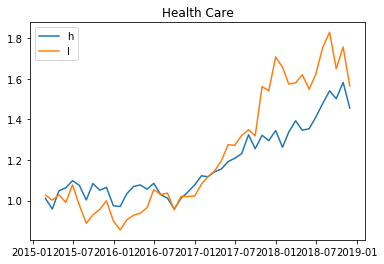

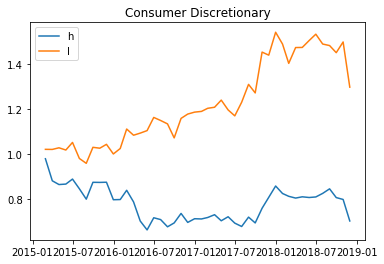

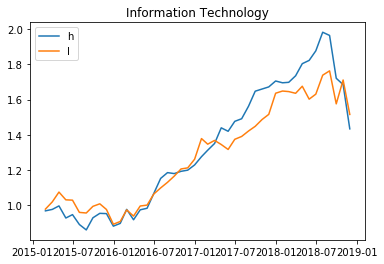

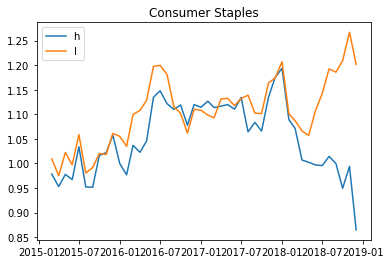

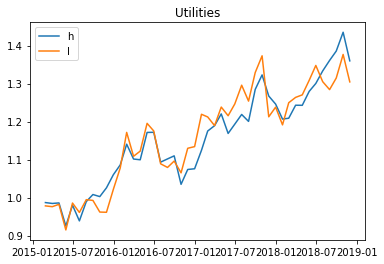

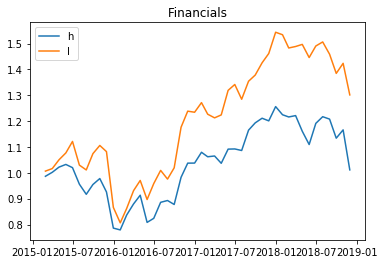

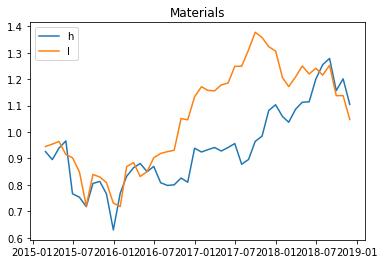

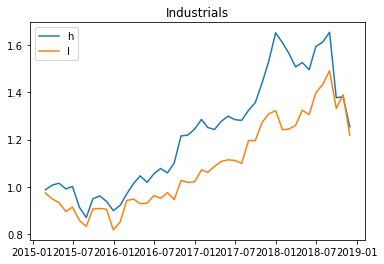

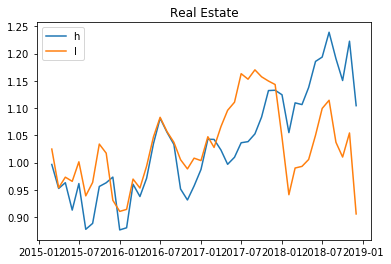

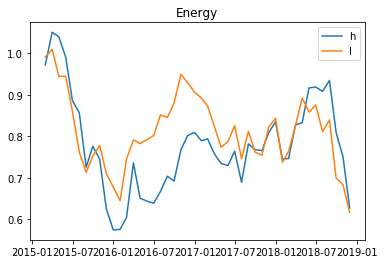

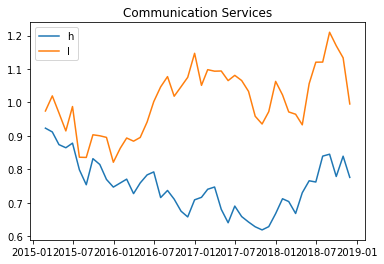

In [201]:
# compute sdg_zscore_change 
date_list = list(group_1['DATE'].unique())

for sector in company_list:
    high_return = []
    low_return = []
    time_frame = []

    for time in date_list:

        group_1 = group_monthly[group_monthly['Sector']==sector]

        num = group_1[group_1['DATE']==time].sort_values(by = 'z_score_change',ascending=False).shape[0]
        high_low_size = round(num*0.15)

        index = date_list.index(time) + 1
        #high_group is the list that includes all the companies with high sdg scores
        high_group = list(group_1[group_1['DATE']==time].sort_values(by = 'z_score_change',ascending=False)['Ticker'].iloc[0:high_low_size].values)
        low_group = list(group_1[group_1['DATE']==time].sort_values(by = 'z_score_change',ascending=False)['Ticker'].iloc[-high_low_size:].values)

        #high_monthly is the dataframe that includes high sdg change stocks with monthly return 
        high_monthly = return_monthly.loc[return_monthly['Ticker'].isin(high_group)]
        low_monthly = return_monthly.loc[return_monthly['Ticker'].isin(low_group)]

        high_monthly = high_monthly.loc[high_monthly['Date'].isin(date_list)]
        low_monthly = low_monthly.loc[low_monthly['Date'].isin(date_list)]

        if index < len(date_list):
            return_h = high_monthly[high_monthly['Date']==date_list[index]]['Log_ret'].mean()
            return_l = low_monthly[low_monthly['Date']==date_list[index]]['Log_ret'].mean()

            time_frame.append(time)
            high_return.append(return_h)
            low_return.append(return_l)
            
    high_return = np.array(high_return) +1
    low_return = np.array(low_return) +1
    high_return = np.cumprod(high_return)
    low_return = np.cumprod(low_return)
            
    plt.plot(time_frame,high_return)
    plt.plot(time_frame,low_return)
    plt.legend('hl')
    plt.title(sector)
    plt.show()
#group_1.sort_values( ['DATE','z_score_change'],ascending= ['True','True'])

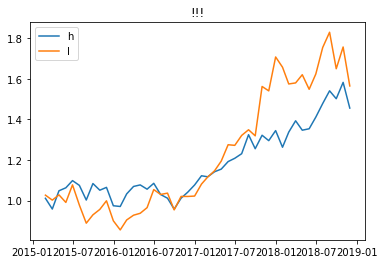

In [192]:
plt.plot(time_frame,high_return)
plt.plot(time_frame,low_return)
plt.legend('hl')
plt.title('!!!')
plt.show()

In [154]:
date_list.index(date_list[4])

4

In [172]:
num = group_1[group_1['DATE']==date_list[0]].sort_values(by = 'z_score_change',ascending=False).shape[0]
high_low_size = round(num*0.15)

index = date_list.index(date_list[0]) + 1
#high_group is the list that includes all the companies with high sdg scores
high_group = list(group_1[group_1['DATE']==date_list[0]].sort_values(by = 'z_score_change',ascending=False)['Ticker'].iloc[0:high_low_size].values)
low_group = list(group_1[group_1['DATE']==date_list[0]].sort_values(by = 'z_score_change',ascending=False)['Ticker'].iloc[-high_low_size:].values)

#high_monthly is the dataframe that includes high sdg change stocks with monthly return 
high_monthly = return_monthly.loc[return_monthly['Ticker'].isin(high_group)]
low_monthly = return_monthly.loc[return_monthly['Ticker'].isin(low_group)]

high_monthly = high_monthly.loc[high_monthly['Date'].isin(date_list)]
low_monthly = low_monthly.loc[low_monthly['Date'].isin(date_list)]

In [174]:
high_monthly[high_monthly['Date']==date_list[index]]

,Ticker,Date,Log_ret
290,ABT,2015-03-31,-0.02220
1298,AMGN,2015-03-31,0.01341
2786,BSX,2015-03-31,0.04907
3452,CELG,2015-03-31,-0.05280
6668,EW,2015-03-31,0.06856
10561,LLY,2015-03-31,0.03473
17200,VRTX,2015-03-31,-0.01230


In [170]:
high_monthly[high_monthly['Date']==date_list[1]]['Log_ret']

290     -0.02220
1298     0.01341
2786     0.04907
3452    -0.05280
6668     0.06856
10561    0.03473
17200   -0.01230
Name: Log_ret, dtype: float64

In [165]:
#return_monthly[return_monthly['Ticker']==high_group[0]]
high_monthly = return_monthly.loc[return_monthly['Ticker'].isin(high_group)]
low_monthly = return_monthly.loc[return_monthly['Ticker'].isin(low_group)]

high_monthly = high_monthly.loc[high_monthly['Date'].isin(date_list)]
low_monthly = low_monthly.loc[low_monthly['Date'].isin(date_list)]



In [168]:
high_monthly

,Ticker,Date,Log_ret
289,ABT,2015-02-28,0.05667
290,ABT,2015-03-31,-0.02220
291,ABT,2015-04-30,0.00709
292,ABT,2015-05-31,0.04589
293,ABT,2015-06-30,0.00983
294,ABT,2015-07-31,0.03709
295,ABT,2015-08-31,-0.11264
296,ABT,2015-09-30,-0.11872
297,ABT,2015-10-31,0.11369
298,ABT,2015-11-30,0.00267


In [34]:
#data.groupby('Ticker').resample('W-Mon').agg({'return_daily':lambda x :x.sum()}).head()

In [ ]:
r.agg({'result' : lambda x: x.mean() / x.std(),
           'total' : np.sum})

In [52]:
df3 = df3.merge(data,on=['Date','Ticker'],how='outer')
df3 = df3.drop(columns=['Adj_Close'])
df3.head()

,Date,z_score_change,Sector,Ticker,return_daily,return_sp,excess_return
0,2015-07-06,0.32084,Health Care,A,-0.00556,-0.00386,-0.00170
1,2015-07-13,-0.40876,Health Care,A,0.01421,0.01107,0.00315
2,2015-07-20,0.13351,Health Care,A,0.00275,0.00077,0.00198
3,2015-07-27,-0.21107,Health Care,A,0.00763,-0.00578,0.01341
4,2015-08-03,0.25544,Health Care,A,0.00122,-0.00276,0.00398


In [298]:
df3['excess_return'] = df3['return_daily'] - df3['return_sp']

In [55]:
high_sdg

['CERN', 'ALNY', 'JNJ', 'A', 'AMGN', 'LLY', 'SYK']

In [57]:
df4.shape

(47, 7)

In [54]:
df4 = df3[df3['Sector']=='Health Care']
num_of_company = df4[df4['Date']==df4['Date'].iloc[0]].sort_values(by=['z_score_change'],ascending=False).shape[0]
df4 = df4[df4['Date']==df4['Date'].iloc[0]].sort_values(by=['z_score_change'],ascending=False)
num = round(num_of_company*0.15)
high_sdg = list(df4['Ticker'].iloc[:num].values)
low_sdg = list(df4['Ticker'].iloc[-num:].values)

#high = df3['Ticker'].apply(lambda x : x if x in high_sdg else False)
#low = df3['Ticker'].apply(lambda x : x if x in low_sdg else False)
#high = df3[high!=False]
#low = df3[low!=False]

#date_high = high.groupby('Date')['excess_return'].sum().index
#date_low = low.groupby('Date')['excess_return'].sum().index

#return_high = high.groupby('Date')['excess_return'].sum().values
#return_low = low.groupby('Date')['excess_return'].sum().values

In [59]:
data.head()

,Date,Adj_Close,Ticker,return_daily,return_sp,excess_return
0,2015-01-05,60.41152,KLAC,-0.02234,-0.01828,-0.00406
1,2015-01-05,92.25000,URI,-0.10947,-0.01828,-0.09119
2,2015-01-05,95.38000,ALNY,-0.02445,-0.01828,-0.00617
3,2015-01-05,28.02279,SCHW,-0.03342,-0.01828,-0.01514
4,2015-01-05,45.15427,DRI,-0.00736,-0.01828,0.01092


In [68]:
high  = data['Ticker'].apply(lambda x :x if x in high_sdg else False)
low  = data['Ticker'].apply(lambda x :x if x in low_sdg else False)
high = data[high!=False]
low = data[low!=False]

#high.set_index('Date')
#low.set_index('Date')

#high = high.drop(columns='Date')
#low = low.drop(columns = 'Date')


date_high = high.groupby('Date')['return_daily'].mean().index
date_low = low.groupby('Date')['return_daily'].mean().index


return_high = high.groupby('Date')['return_daily'].mean().values
return_low = low.groupby('Date')['return_daily'].mean().values


In [67]:
high.groupby('Date')['return_daily'].mean()

Date
2015-01-05   -0.01436
2015-01-06   -0.01049
2015-01-07    0.01452
2015-01-08    0.02414
2015-01-09   -0.01036
2015-01-12   -0.00050
2015-01-13    0.00018
2015-01-14   -0.00670
2015-01-15   -0.01974
2015-01-16    0.01907
2015-01-20   -0.01195
2015-01-21   -0.00927
2015-01-22    0.02557
2015-01-23   -0.00615
2015-01-26    0.00564
2015-01-27   -0.00434
2015-01-28   -0.01661
2015-01-29    0.01321
2015-01-30   -0.01504
2015-02-02    0.00362
2015-02-03    0.00130
2015-02-04   -0.01218
2015-02-05    0.01897
2015-02-06   -0.00967
2015-02-09   -0.01091
2015-02-10    0.01957
2015-02-11    0.00032
2015-02-12    0.00680
2015-02-13    0.00916
2015-02-17    0.00530
               ...   
2018-11-15    0.02246
2018-11-16    0.01769
2018-11-19   -0.01152
2018-11-20    0.01069
2018-11-21   -0.01028
2018-11-23    0.00445
2018-11-26    0.01616
2018-11-27    0.00674
2018-11-28    0.01760
2018-11-29    0.00363
2018-11-30    0.01491
2018-12-03    0.00484
2018-12-04   -0.02590
2018-12-06   -0.00252
2018-

In [377]:
date_high

DatetimeIndex(['2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-12', '2015-01-13', '2015-01-14',
               '2015-01-15', '2015-01-16',
               ...
               '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20',
               '2018-12-21', '2018-12-24', '2018-12-26', '2018-12-27',
               '2018-12-28', '2018-12-31'],
              dtype='datetime64[ns]', name='Date', length=1005, freq=None)

C:\Program1\Anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


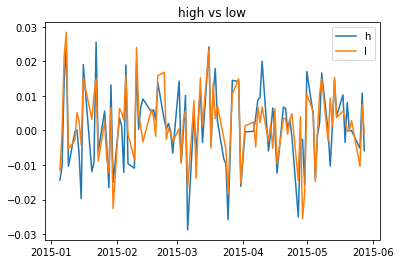

In [69]:
plt.plot(date_high[:100],return_high[:100])
plt.plot(date_low[:100],return_low[:100])
plt.title('high vs low')
plt.legend('hl')
plt.show()

In [48]:
for i in company_list:
    print(df3[df3['Sector']==i].head())

        Date  excess_return  z_score_change       Sector Ticker
0 2015-07-06        0.01049         0.32084  Health Care      A
1 2015-07-13        0.00033        -0.40876  Health Care      A
2 2015-07-20       -0.01107         0.13351  Health Care      A
3 2015-07-27        0.01761        -0.21107  Health Care      A
4 2015-08-03        0.01989         0.25544  Health Care      A
          Date  excess_return  z_score_change                  Sector Ticker
183 2015-07-06        0.02247         0.63847  Consumer Discretionary    AAP
184 2015-07-13        0.02061        -0.40109  Consumer Discretionary    AAP
185 2015-07-20       -0.01724         0.00000  Consumer Discretionary    AAP
186 2015-07-27        0.02683         0.12215  Consumer Discretionary    AAP
187 2015-08-03        0.01738        -0.12215  Consumer Discretionary    AAP
          Date  excess_return  z_score_change                  Sector Ticker
366 2015-07-06        0.00635         0.65706  Information Technology   AAPL
